In [1]:
import os
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../../hetnet-ml/src')
import plot_tools as pt

In [2]:
load_dir = '../2_pipeline/02_n_fold_CV_training/out/'

coef = pd.read_csv(os.path.join(load_dir, 'model_coefficients.csv'))
preds = pd.read_csv(os.path.join(load_dir, 'predictions.csv'))

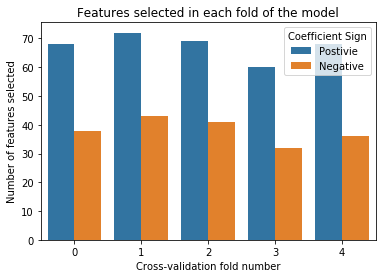

In [3]:
cols = [c for c in coef.columns if c.startswith('coef_')]
pos_counts = (coef[cols] > 0).sum().rename('value').to_frame().reset_index().rename(columns={'index': 'fold'})
pos_counts['Coefficient Sign'] = 'Postivie'

neg_counts = (coef[cols] < 0).sum().rename('value').to_frame().reset_index().rename(columns={'index': 'fold'})
neg_counts['Coefficient Sign'] = 'Negative'

coef_counts = pd.concat([pos_counts, neg_counts])
coef_counts['fold'] = coef_counts['fold'].map(lambda v: v.split('_')[-1]).astype(int)

sns.barplot(x='fold', y='value', data=coef_counts, hue='Coefficient Sign')
plt.title('Features selected in each fold of the model')

plt.xlabel('Cross-validation fold number')
plt.ylabel('Number of features selected');

In [4]:
import json
load_dir = '../2_pipeline/00_hetnet_design_and_build/out'
node_info = json.load(open(os.path.join(load_dir, 'node_info.json'), 'r'))
edge_info = json.load(open(os.path.join(load_dir, 'edge_info.json'), 'r'))

In [5]:
node_abv_to_full = {v['abbrev']: k for k, v in node_info.items()}
edge_abv_to_full = {v['abbrev']: k for k, v in edge_info.items()}

In [6]:
def metapath_to_abbrevs(mp):
    
    # sometimes dwpc_abbrev so just split that out
    if '_' in mp:
        mp = mp.split('_')[-1]
    
    node_idx = [i for i, x in enumerate(mp) if x.upper() == x]
    edge_idx = [i for i, x in enumerate(mp) if x.lower() == x]
    
    split_abbrevs = []
    now_node = True
    curr_abbrev = ''
    
    for i, x in enumerate(mp):
        if i in node_idx: 
            if not now_node:
                split_abbrevs.append(curr_abbrev)
                curr_abbrev = ''
                now_node = True
            curr_abbrev += x
        elif i in edge_idx :
            if now_node:
                split_abbrevs.append(curr_abbrev)
                curr_abbrev = ''
                now_node = False
            curr_abbrev += x
    split_abbrevs.append(curr_abbrev)
        
    
    return split_abbrevs

In [7]:
def mp_abbrev_to_name(mp_abrev):
    out = []
    for i, abv in enumerate(metapath_to_abbrevs(mp_abrev)):
        if i % 2 == 0:
            out.append(node_abv_to_full[abv])
        else:
            out.append(edge_abv_to_full[abv])
    return out

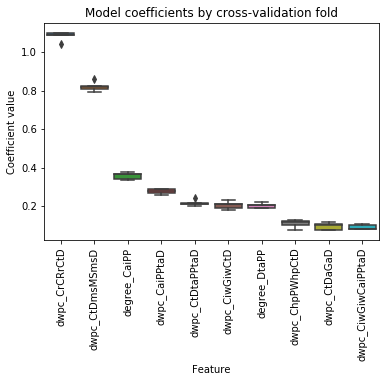

In [8]:
coef['mean_coef'] = coef[cols].mean(axis=1)
unweight_trans_coef = pd.melt(coef.sort_values('mean_coef', ascending=False), id_vars=['feature'], value_vars=cols)
top_features = unweight_trans_coef['feature'][:10].values

data = unweight_trans_coef.query('feature in @top_features')

sns.boxplot(x='feature', y='value', data=data)
plt.xlabel('Feature')
plt.ylabel('Coefficient value')
plt.title('Model coefficients by cross-validation fold')
plt.xticks(rotation=90);

In [9]:
for coef_name in top_features:
    print('{!r}'.format(mp_abbrev_to_name(coef_name)))

['Compound', 'HAS_ROLE', 'Chemical Role', 'HAS_ROLE', 'Compound', 'TREATS', 'Disease']
['Compound', 'TREATS', 'Disease', 'MEDICAL_SPECIALTY', 'Medical Specialty', 'MEDICAL_SPECIALTY', 'Disease']
['Compound', 'HAS_ACTIVE_INGREDIENT', 'Pharmaceutical Product']
['Compound', 'HAS_ACTIVE_INGREDIENT', 'Pharmaceutical Product', 'THERAPEUTIC_AREA', 'Disease']
['Compound', 'TREATS', 'Disease', 'THERAPEUTIC_AREA', 'Pharmaceutical Product', 'THERAPEUTIC_AREA', 'Disease']
['Compound', 'PHYSICALLY_INTERACTS_WITH', 'Gene', 'PHYSICALLY_INTERACTS_WITH', 'Compound', 'TREATS', 'Disease']
['Disease', 'THERAPEUTIC_AREA', 'Pharmaceutical Product']
['Compound', 'HAS_PART', 'Biological Pathway', 'HAS_PART', 'Compound', 'TREATS', 'Disease']
['Compound', 'TREATS', 'Disease', 'GENETIC_ASSOCIATION', 'Gene', 'GENETIC_ASSOCIATION', 'Disease']
['Compound', 'PHYSICALLY_INTERACTS_WITH', 'Gene', 'PHYSICALLY_INTERACTS_WITH', 'Compound', 'HAS_ACTIVE_INGREDIENT', 'Pharmaceutical Product', 'THERAPEUTIC_AREA', 'Disease']


In [10]:
def find_coefs_containing(abbrev):
    abbvs = []
    mps = []
    coef_vals = []
    for mp in coef.query('mean_coef != 0').sort_values('mean_coef', ascending=False)['feature']:
        if abbrev in metapath_to_abbrevs(mp):
            mps.append('-'.join(mp_abbrev_to_name(mp)))
            coef_vals.append(coef.set_index('feature').loc[mp, 'mean_coef'])
            abbvs.append(mp)
    return pd.DataFrame({'feature': mps, 'abbrev': abbvs, 'value': coef_vals})
            

In [29]:
def print_coefs_containing(abbrev):
    for row in find_coefs_containing(abbrev).itertuples():
        print(row.feature)
        print(row.abbrev, ':', row.value)
        print('')

In [30]:
print_coefs_containing('BP')

Compound-PHYSICALLY_INTERACTS_WITH-Gene-BIOLOGICAL_PROCESS-Biological Process-BIOLOGICAL_PROCESS-Gene-GENETIC_ASSOCIATION-Disease
dwpc_CiwGbpBPbpGaD : 0.0037343262373665115



In [33]:
print_coefs_containing('MF')

In [34]:
print_coefs_containing('CC')

Compound-PHYSICALLY_INTERACTS_WITH-Gene-CELL_COMPONENT-Cellular Component-CELL_COMPONENT-Gene-GENETIC_ASSOCIATION-Disease
dwpc_CiwGccCCccGaD : 0.02029918108966715



In [36]:
print_coefs_containing('PF')

In [37]:
print_coefs_containing('SS')

Compound-PHYSICALLY_INTERACTS_WITH-Gene-HAS_PART-Super-Secondary Structure-HAS_PART-Gene-GENETIC_ASSOCIATION-Disease
dwpc_CiwGhpSShpGaD : 0.00283925812781592



In [38]:
print_coefs_containing('SM')

Compound-PHYSICALLY_INTERACTS_WITH-Gene-HAS_PART-Structural Motif-HAS_PART-Gene-GENETIC_ASSOCIATION-Disease
dwpc_CiwGhpSMhpGaD : 0.003972107289110216



In [39]:
print_coefs_containing('PD')

Compound-PHYSICALLY_INTERACTS_WITH-Gene-HAS_PART-Protein Domain-HAS_PART-Gene-GENETIC_ASSOCIATION-Disease
dwpc_CiwGhpPDhpGaD : 0.001259938843375525



In [40]:
print_coefs_containing('BS')

Compound-PHYSICALLY_INTERACTS_WITH-Gene-HAS_PART-Binding Site-HAS_PART-Gene-GENETIC_ASSOCIATION-Disease
dwpc_CiwGhpBShpGaD : -0.01189464401304892



In [40]:
print_coefs_containing('BS')

Compound-PHYSICALLY_INTERACTS_WITH-Gene-HAS_PART-Binding Site-HAS_PART-Gene-GENETIC_ASSOCIATION-Disease
dwpc_CiwGhpBShpGaD : -0.01189464401304892



In [35]:
print_coefs_containing('AS')

Compound-PHYSICALLY_INTERACTS_WITH-Gene-HAS_PART-Active Site-HAS_PART-Gene-GENETIC_ASSOCIATION-Disease
dwpc_CiwGhpAShpGaD : -0.019140009691549276



In [42]:
find_coefs_containing('V')

,feature,abbrev,value
0,Compound-POSITIVE_THERAPEUTIC_PREDICTOR-Sequen...,dwpc_CptVptCtD,0.084955
1,Compound-NEGATIVE_THERAPEUTIC_PREDICTOR-Sequen...,dwpc_CntVntCtD,0.071820
2,Compound-NEGATIVE_THERAPEUTIC_PREDICTOR-Sequen...,degree_CntV,0.038334
3,Compound-TREATS-Disease-GENETIC_ASSOCIATION-Ge...,dwpc_CtDaGvVpdD,0.036379
4,Disease-NEGATIVE_DIAGNOSTIC_PREDICTOR-Sequence...,degree_DndV,0.034451
5,Compound-NEGATIVE_THERAPEUTIC_PREDICTOR-Sequen...,dwpc_CntVptCaiPPtaD,0.030747
6,Compound-NEGATIVE_THERAPEUTIC_PREDICTOR-Sequen...,dwpc_CntVptCtD,0.027995
7,Compound-POSITIVE_THERAPEUTIC_PREDICTOR-Sequen...,dwpc_CptVntCtD,0.026386
8,Compound-NEGATIVE_THERAPEUTIC_PREDICTOR-Sequen...,dwpc_CntVvGiwCtD,0.022489
9,Compound-POSITIVE_THERAPEUTIC_PREDICTOR-Sequen...,dwpc_CptVpdD,0.021832


In [43]:
find_coefs_containing('PW')

,feature,abbrev,value
0,Compound-HAS_PART-Biological Pathway-HAS_PART-...,dwpc_ChpPWhpCtD,0.108579
1,Compound-HAS_PART-Biological Pathway-HAS_PART-...,dwpc_ChpPWhpGiwCtD,0.042180
2,Compound-PHYSICALLY_INTERACTS_WITH-Gene-HAS_PA...,dwpc_CiwGhpPWhpCtD,0.024431
3,Compound-HAS_PART-Biological Pathway-HAS_PART-...,dwpc_ChpPWhpChcCHsyD,0.019560
4,Compound-HAS_PART-Biological Pathway-HAS_PART-...,dwpc_ChpPWhpCtCHsyD,0.011498
5,Compound-HAS_PART-Biological Pathway-HAS_PART-...,dwpc_ChpPWhpCptVndD,0.002599
6,Compound-HAS_PART-Biological Pathway-HAS_PART-...,dwpc_ChpPWhpCptVpdD,0.002209
7,Compound-HAS_PART-Biological Pathway-HAS_PART-...,dwpc_ChpPWhpGaD,0.001435
8,Compound-SIGNIFICANT_DRUG_INTERACTION-Compound...,dwpc_CdiChpPWhpGaD,0.001385
9,Compound-PHYSICALLY_INTERACTS_WITH-Gene-HAS_PA...,dwpc_CiwGhpPWhpGaD,-0.004573


In [13]:
n_folds = 5

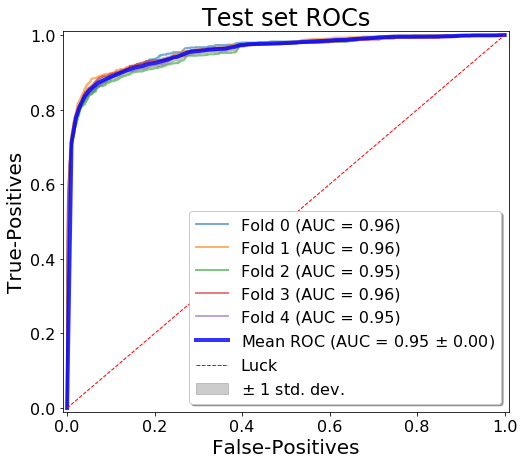

In [14]:
ys = []
y_preds = []
for fold in range(n_folds):
    y_true = preds.query("holdout_fold == @fold")['status'].values
    y_pred = preds.query("holdout_fold == @fold")['probas_{}'.format(fold)].values

    ys.append(y_true)
    y_preds.append(y_pred)

    pt.graph_single_roc(y_true, y_pred, 'Fold {}'.format(fold), alpha=.6, lw=2)

pt.graph_mean_roc(ys, y_preds, lw=4)

fig = pt.graph_roc_boilerplate('Test set ROCs')

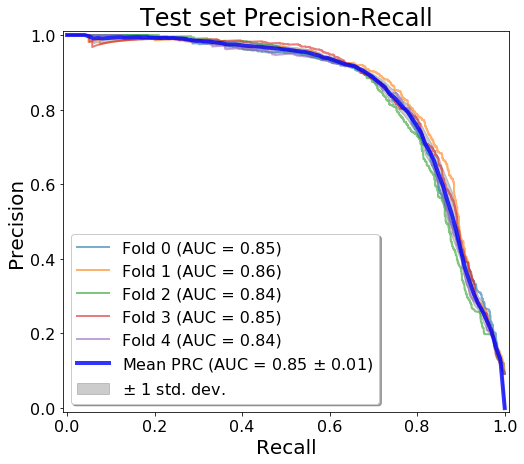

In [44]:
ys = []
y_preds = []
for fold in range(n_folds):
    y_true = preds.query("holdout_fold == @fold")['status'].values
    y_pred = preds.query("holdout_fold == @fold")['probas_{}'.format(fold)].values

    ys.append(y_true)
    y_preds.append(y_pred)

    pt.graph_single_prc(y_true, y_pred, 'Fold {}'.format(fold), alpha=.6, lw=2)

pt.graph_mean_prc(ys, y_preds, lw=4)

fig = pt.graph_prc_boilerplate('Test set Precision-Recall')

In [15]:
def percentile_to_rank(col, total_elements):
    return np.round(-1*total_elements * col + (total_elements + 1)).astype(int)

In [16]:
for i in range(n_folds):
    preds['d_rank_{}'.format(i)] = percentile_to_rank(preds['d_percentile_{}'.format(i)], preds['c_id'].nunique())
    preds['c_rank_{}'.format(i)] = percentile_to_rank(preds['c_percentile_{}'.format(i)], preds['d_id'].nunique())


In [17]:
cutoffs = [20, 100]
rank_cats = ['Top {}'.format(cutoffs[0]), '{}-{}'.format(cutoffs[0]+1, cutoffs[1]), '> {}'.format(cutoffs[1])]

def get_rank_cat(rank):
    if rank <= cutoffs[0]:
        return rank_cats[0]
    
    elif rank > cutoffs[0] and rank <= cutoffs[1]:
        return rank_cats[1]
    
    else:
        return rank_cats[2]

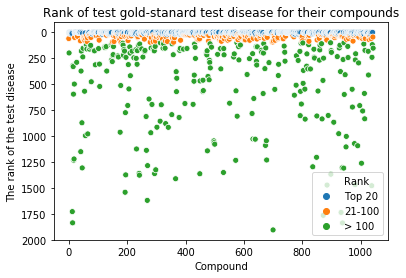

In [18]:
test_fold = 0

curr_fold_test_cd_ranks = preds.query('holdout_fold == @test_fold and status == 1')[['c_id',
                                'd_id', 'c_rank_{}'.format(test_fold)]].reset_index(drop=True)

curr_fold_test_cd_ranks['Rank'] = curr_fold_test_cd_ranks['c_rank_{}'.format(test_fold)].apply(lambda r: get_rank_cat(r))


ax = sns.scatterplot(x='index', y='c_rank_{}'.format(test_fold), data=curr_fold_test_cd_ranks.reset_index(),
                     hue='Rank', hue_order=rank_cats)

plt.title('Rank of test gold-stanard test disease for their compounds')
plt.xlabel('Compound')
plt.ylabel('The rank of the test disease')
plt.legend(loc='lower right')

ax.invert_yaxis();

/home/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


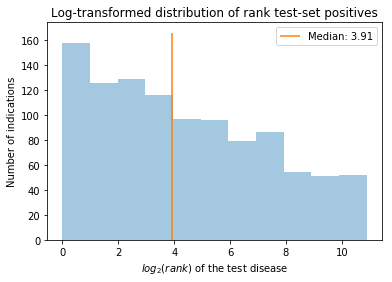

In [19]:
curr_fold_test_cd_ranks['log_rank'] = np.log2(curr_fold_test_cd_ranks['c_rank_{}'.format(test_fold)])

sns.distplot(curr_fold_test_cd_ranks['log_rank'], kde=False)
plt.title('Log-transformed distribution of rank test-set positives')
plt.xlabel(r'$log_2(rank)$'+' of the test disease')
plt.ylabel('Number of indications')

med = curr_fold_test_cd_ranks['log_rank'].median()
b, t = plt.ylim()

plt.vlines(med, b, t, colors=sns.color_palette()[1], label='Median: {:.2f}'.format(med))
plt.legend();

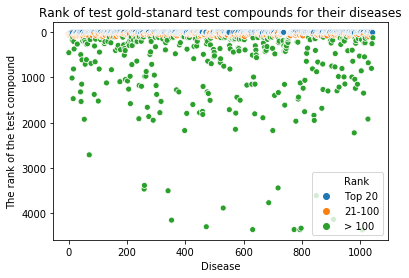

In [20]:
test_fold = 0

curr_fold_test_d_ranks = preds.query('holdout_fold == @test_fold and status == 1')[['c_id',
                                'd_id', 'd_rank_{}'.format(test_fold)]].reset_index(drop=True)

curr_fold_test_d_ranks['Rank'] = curr_fold_test_d_ranks['d_rank_{}'.format(test_fold)].apply(lambda r: get_rank_cat(r))


ax = sns.scatterplot(x='index', y='d_rank_{}'.format(test_fold), data=curr_fold_test_d_ranks.reset_index(),
                     hue='Rank', hue_order=rank_cats)

plt.title('Rank of test gold-stanard test compounds for their diseases')
plt.xlabel('Disease')
plt.ylabel('The rank of the test compound')
plt.legend(loc='lower right')

ax.invert_yaxis();

/home/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


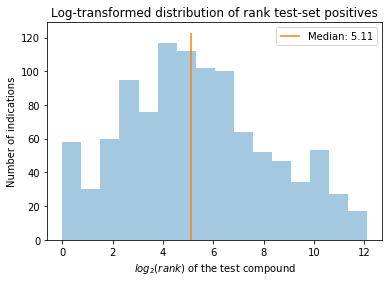

In [21]:
curr_fold_test_d_ranks['log_rank'] = np.log2(curr_fold_test_d_ranks['d_rank_{}'.format(test_fold)])

sns.distplot(curr_fold_test_d_ranks['log_rank'.format(test_fold)], kde=False)
plt.title('Log-transformed distribution of rank test-set positives')
plt.xlabel(r'$log_2(rank)$'+' of the test compound')
plt.ylabel('Number of indications')

med = curr_fold_test_d_ranks['log_rank'].median()
b, t = plt.ylim()

plt.vlines(med, b, t, colors=sns.color_palette()[1], label='Median: {:.2f}'.format(med))
plt.legend();